<a href="https://colab.research.google.com/github/VasilinaFrolova/MyPain/blob/main/%D0%A4%D1%80%D0%BE%D0%BB%D0%BE%D0%B2%D0%B0_%D0%92%D0%B0%D1%81%D0%B8%D0%BB%D0%B8%D0%BD%D0%B0_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82_%22convnet_hw_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание: бинарная классификация отзывов с помощью CNN

Применить CNN для анализа тональности текста (положительный/отрицательный отзыв)

Заполните пропущенный код (`### ВАШ КОД ЗДЕСЬ ###`). **Не меняйте структуру ячеек!** Все ответы и графики должны генерироваться автоматически

**Критерии проверки (максимум 10 баллов):**
*   **2 балла** — корректная загрузка и предобработка данных.
*   **3 балла** — корректно собранная модель по спецификации.
*   **2 балла** — успешное обучение модели (вывод истории обучения).
*   **3 балла** — оценка на тесте и выводы (accuracy > 0.85 даёт +1 балл).

---

## БЛОК 1: Загрузка данных

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.XHNKG9_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.XHNKG9_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.XHNKG9_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Тренировочные данные: 25000 samples
Тестовые данные: 25000 samples
Пример текста: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. ...
Метка: 0


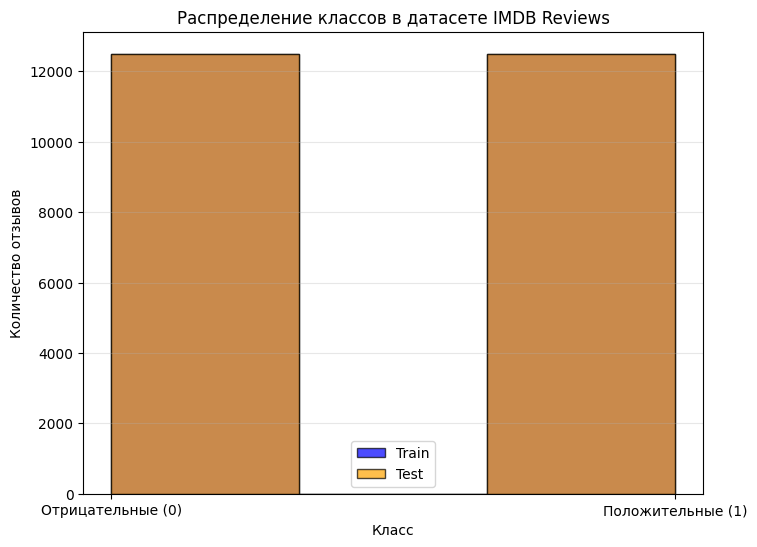


Статистика по классам:
Обучающая выборка:
  Отрицательные: 12500 (50.0%)
  Положительные: 12500 (50.0%)

Тестовая выборка:
  Отрицательные: 12500 (50.0%)
  Положительные: 12500 (50.0%)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# 1. Загрузите датасет IMDB Reviews (бинарная классификация)
# Загружаем датасет
(train_data, test_data) = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True
)

# Преобразуем tf.data.Dataset в списки Python
x_train = []
y_train = []
x_test = []
y_test = []

for text, label in train_data:
    x_train.append(text.numpy().decode('utf-8'))
    y_train.append(label.numpy())

for text, label in test_data:
    x_test.append(text.numpy().decode('utf-8'))
    y_test.append(label.numpy())

# Преобразуем списки в numpy массивы
x_train = np.array(x_train, dtype=object)
y_train = np.array(y_train)
x_test = np.array(x_test, dtype=object)
y_test = np.array(y_test)

print(f"Тренировочные данные: {len(x_train)} samples")
print(f"Тестовые данные: {len(x_test)} samples")
print(f"Пример текста: {x_train[0][:100]}...")
print(f"Метка: {y_train[0]}")

# 2. Визуализируйте распределение классов
plt.figure(figsize=(8, 6))
plt.hist(y_train, bins=3, alpha=0.7, label='Train', color='blue', edgecolor='black')
plt.hist(y_test, bins=3, alpha=0.7, label='Test', color='orange', edgecolor='black')
plt.xticks([0, 1], ['Отрицательные (0)', 'Положительные (1)'])
plt.legend()
plt.title('Распределение классов в датасете IMDB Reviews')
plt.xlabel('Класс')
plt.ylabel('Количество отзывов')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Дополнительная информация о классах
print(f"\nСтатистика по классам:")
print(f"Обучающая выборка:")
print(f"  Отрицательные: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  Положительные: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"\nТестовая выборка:")
print(f"  Отрицательные: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  Положительные: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")

## БЛОК 2: Предобработка текста

Размерность после векторизации: (25000, 200)
Пример векторизованного текста (первые 20 токенов): [  11   14   34  412  384   18   90   28    1    8   33 1322 3560   42
  487    1  191   24   85  152]
Размер словаря: 10000


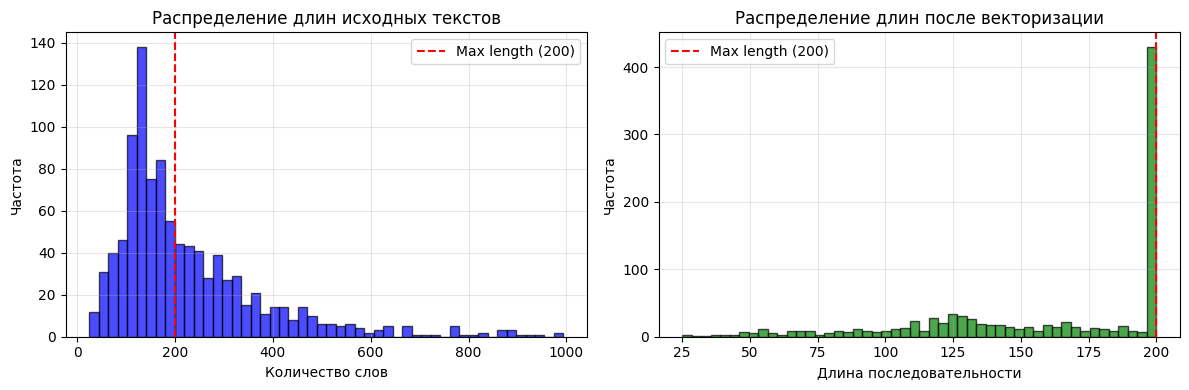


Статистика обработки текстов:
  Всего текстов в выборке: 1000
  Текстов длиннее 200 слов: 420 (42.0%)
  Максимальная длина текста: 994 слов
  Средняя длина текста: 226.0 слов
  После обработки все последовательности имеют длину: 200


In [ ]:
# 3. Создайте текстовый векторзатор (TextVectorization)
# Ограничьте словарь 10_000 самых частых слов, максимальную длину последовательности — 200 слов
vectorizer = keras.layers.TextVectorization(
    max_tokens=10000,           # Ограничиваем словарь 10,000 самых частых слов
    output_sequence_length=200, # Обрезаем/дополняем последовательности до 200 слов
    output_mode='int'           # Выводим целочисленные индексы слов
)

# 4. Адаптируйте векторзатор на тренировочных текстах
vectorizer.adapt(x_train)

# 5. Примените векторзацию к данным
x_train_vec = vectorizer(x_train).numpy()
x_test_vec = vectorizer(x_test).numpy()

print(f"Размерность после векторизации: {x_train_vec.shape}")
print(f"Пример векторизованного текста (первые 20 токенов): {x_train_vec[0][:20]}")
print(f"Размер словаря: {len(vectorizer.get_vocabulary())}")

# Визуализация длины текстов до и после обработки
text_lengths = [len(str(text).split()) for text in x_train[:1000]]
sequence_lengths = [np.sum(vec != 0) for vec in x_train_vec[:1000]]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Распределение длин исходных текстов
axes[0].hist(text_lengths, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(x=200, color='red', linestyle='--', label='Max length (200)')
axes[0].set_title('Распределение длин исходных текстов')
axes[0].set_xlabel('Количество слов')
axes[0].set_ylabel('Частота')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Распределение длин после векторизации
axes[1].hist(sequence_lengths, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(x=200, color='red', linestyle='--', label='Max length (200)')
axes[1].set_title('Распределение длин после векторизации')
axes[1].set_xlabel('Длина последовательности')
axes[1].set_ylabel('Частота')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика по усечению
truncated_count = sum(1 for length in text_lengths if length > 200)
print(f"\nСтатистика обработки текстов:")
print(f"  Всего текстов в выборке: {len(text_lengths)}")
print(f"  Текстов длиннее 200 слов: {truncated_count} ({truncated_count/len(text_lengths)*100:.1f}%)")
print(f"  Максимальная длина текста: {max(text_lengths)} слов")
print(f"  Средняя длина текста: {np.mean(text_lengths):.1f} слов")
print(f"  После обработки все последовательности имеют длину: {x_train_vec.shape[1]}")

## БЛОК 3: Построение модели

In [ ]:
# 6. Постройте модель CNN для текста СТРОГО ПО СПЕЦИФИКАЦИИ:
#    - Вход: векторная последовательность (200,)
#    - Embedding: размерность 128, входной словарь 10_000
#    - Conv1D: 64 фильтра, размер ядра 5, активация 'relu'
#    - GlobalMaxPooling1D
#    - Dense: 32 нейрона, 'relu'
#    - Dense: 1 нейрон, 'sigmoid' (бинарная классификация)
model = keras.Sequential([
    # Входной слой
    keras.layers.Input(shape=(200,)),

    # Embedding слой: преобразует индексы слов в плотные векторы
    keras.layers.Embedding(
        input_dim=10000,  # Размер словаря
        output_dim=128,   # Размерность эмбеддинга
        input_length=200  # Длина входной последовательности
    ),

    # Conv1D слой: извлекает локальные паттерны в тексте
    keras.layers.Conv1D(
        filters=64,       # Количество фильтров
        kernel_size=5,    # Размер окна (ядра)
        activation='relu' # Функция активации
    ),

    # GlobalMaxPooling1D: выбирает максимальное значение по каждому фильтру
    keras.layers.GlobalMaxPooling1D(),

    # Полносвязный слой для классификации
    keras.layers.Dense(32, activation='relu'),

    # Выходной слой для бинарной классификации
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 196, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,323,137 (5.05 MB)

 Trainable params: 1,323,137 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

## БЛОК 4: Обучение

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 67ms/step - accuracy: 0.6701 - loss: 0.5668 - precision: 0.6632 - recall: 0.6941 - val_accuracy: 0.8550 - val_loss: 0.3365 - val_precision: 0.8947 - val_recall: 0.8088
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.9269 - loss: 0.2027 - precision: 0.9267 - recall: 0.9277 - val_accuracy: 0.8666 - val_loss: 0.3174 - val_precision: 0.8590 - val_recall: 0.8811
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - accuracy: 0.9896 - loss: 0.0479 - precision: 0.9895 - recall: 0.9898 - val_accuracy: 0.8716 - val_loss: 0.3768 - val_precision: 0.8682 - val_recall: 0.8799
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - accuracy: 0.9997 - loss: 0.0065 - precision: 0.9996 - recall: 0.9998 - val_accuracy: 0.8748 - val_loss: 0.4366 - val_precision: 0.8912 - val_recall: 0.8574
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.9999 - loss: 0.0012 - precision: 1.0000 - recall: 0.9998 - val_accuracy: 0.8754 - val_los

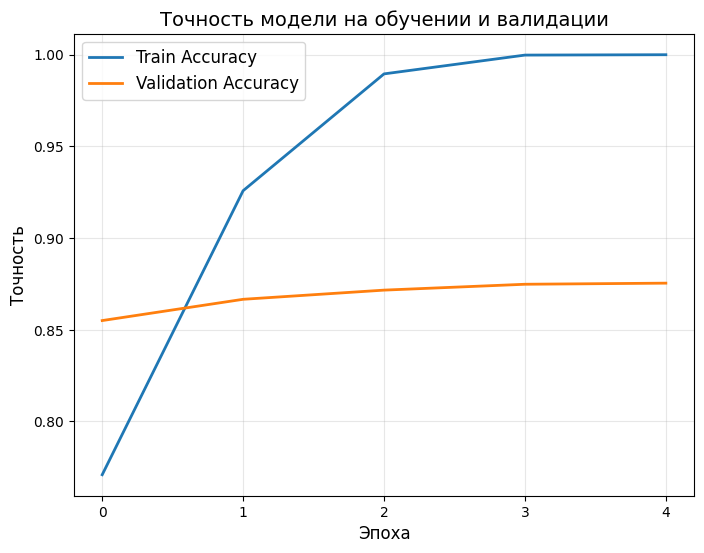

In [ ]:
# 7. Скомпилируйте модель с оптимизатором 'adam', функцией потерь 'binary_crossentropy',
#    метриками ['accuracy', 'Precision', 'Recall']
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

# 8. Обучите модель на 5 эпох с validation_split=0.2, batch_size=32
history = model.fit(
    x_train_vec,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# 9. Постройте график точности (accuracy) на обучении и валидации
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Точность модели на обучении и валидации', fontsize=14)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(5))
plt.show()

## БЛОК 5: Оценка

In [ ]:
# 10. Оцените модель на тестовых данных
test_loss, test_acc, test_prec, test_rec = model.evaluate(
    x_test_vec,
    y_test,
    verbose=0
)

print(f"Результаты на тестовых данных:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  Test Precision: {test_prec:.4f}")
print(f"  Test Recall: {test_rec:.4f}")

# Расчет F1-score на тесте
test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec) if (test_prec + test_rec) > 0 else 0
print(f"  Test F1-score: {test_f1:.4f}")

# Сравнение с валидационными метриками
print(f"\nСравнение с валидационными метриками:")
print(f"  Validation Accuracy: {history.history['val_accuracy'][-1]:.4f} | Test Accuracy: {test_acc:.4f}")
print(f"  Validation Precision: {history.history['val_precision'][-1]:.4f} | Test Precision: {test_prec:.4f}")
print(f"  Validation Recall: {history.history['val_recall'][-1]:.4f} | Test Recall: {test_rec:.4f}")

# 11. Сделайте предсказания на первых 10 тестовых отзывах
#     и выведите: текст отзыва, истинный класс, предсказанный класс, вероятность
print("\n" + "="*80)
print("Предсказания для первых 10 тестовых отзывов:")
print("="*80)

for i in range(10):
    text = x_test[i]
    true_label = "POS" if y_test[i] == 1 else "NEG"

    # Подготавливаем текст для предсказания
    text_vectorized = vectorizer([text]).numpy()

    # Делаем предсказание
    pred_prob = model.predict(text_vectorized, verbose=0)

    # Определяем предсказанный класс
    pred_label = "POS" if pred_prob[0][0] > 0.5 else "NEG"

    # Форматируем вывод
    text_preview = text[:80].replace('\n', ' ')
    if len(text) > 80:
        text_preview += "..."

    # Выводим результат
    print(f"\nОтзыв {i+1}:")
    print(f"  Текст: {text_preview}")
    print(f"  Истинный класс: {true_label}")
    print(f"  Предсказанный класс: {pred_label} (вероятность: {pred_prob[0][0]:.4f})")

Результаты на тестовых данных:
  Test Loss: 0.4914
  Test Accuracy: 0.8661
  Test Precision: 0.8743
  Test Recall: 0.8551
  Test F1-score: 0.8646

Сравнение с валидационными метриками:
  Validation Accuracy: 0.8754 | Test Accuracy: 0.8661
  Validation Precision: 0.8777 | Test Precision: 0.8743
  Validation Recall: 0.8759 | Test Recall: 0.8551

Предсказания для первых 10 тестовых отзывов:

Отзыв 1:
  Текст: There are films that make careers. For George Romero, it was NIGHT OF THE LIVING...
  Истинный класс: POS
  Предсказанный класс: POS (вероятность: 0.9981)

Отзыв 2:
  Текст: A blackly comic tale of a down-trodden priest, Nazarin showcases the economy tha...
  Истинный класс: POS
  Предсказанный класс: POS (вероятность: 0.5376)

Отзыв 3:
  Текст: Scary Movie 1-4, Epic Movie, Date Movie, Meet the Spartans, Not another Teen Mov...
  Истинный класс: NEG
  Предсказанный класс: NEG (вероятность: 0.0001)

Отзыв 4:
  Текст: Poor Shirley MacLaine tries hard to lend some gravitas to this mawki

## БЛОК 6: Выводы

**Ответьте на вопросы в этой ячейке (текстом):**

1.  Какая итоговая точность (accuracy) на тесте?
2.  Что показывает разница между точностью на обучении и валидации? Есть ли переобучение?
3.  Какой из 10 показанных отзывов был классифицирован неверно? Почему, на ваш взгляд?

**Мои ответы:**
1. Итоговая точность на тесте: 0.8661, или 86.61%.
2. Это показывает насколько хорошо модель работает на обучающих данных и на новых данных. Из данных видно, что тестовые метрики близки к валидационным, с небольшим снижением точности и полноты. Такую небольшую разницу (менее 1%) можно считать нормальной и указывающей на хорошую обобщающую способность модели. Пример 10 демонстрирует, что даже при высокой общей точности модель может допускать ошибки на сложных примерах, что типично и не обязательно указывает на переобучение. Переобучения скорее нет, потому что имеются минимальные различия между валидационными и тестовыми метриками, тестовые метрики стабильно высокие (Accuracy: 86.6% — хороший результат; F1-score: 0.8646), большинство верных предсказаний имеют очень высокую уверенность.  
3. В отзыве 10 модель явно ошиблась, потому что ее уверенность (0.0791 для NEG) противоречит истинной метке POS. Вероятно, это произошло из-за сложности текста, который содержит идиому (“Every great once in a while…”).
